In [2]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller, coint
import yfinance as yf
np.random.seed(42)

In [12]:
def fetch_stock(ticker, feature):
    stock = yf.Ticker(ticker)
    hist_df = stock.history(period="max")
    stock_series = hist_df[feature].rename(ticker)
    stock_series.index = stock_series.index.date
    return stock_series

In [35]:
def get_weights_ffd(d, thresh):
    '''
    computes weights for differentiating for fixed window
    ''' 
    # init first weight - always 1.0 for t_0
    w, k = [1.0], 1
    while True:

        # calculate next weight - decays
        w_ = -w[-1] / k * (d - k + 1)

        # break once weights are below threshold
        if abs(w_) < thresh:
            break 

        # append the weight to the list
        w.append(w_)

        # increment k
        k += 1

    # reverse the weights ([w_0, w_1, ..., w_n] -> [w_n, ..., w_1, w_0])
    w = np.array(w[::-1]).reshape(-1, 1)
    return w 

In [83]:
def frac_diff_ffd(series, d, thresh=1e-5):
    ''' 
    fractional differentiation with constant width window 
    ''' 
    # get weights and set window size
    w = get_weights_ffd(d, thresh)  
    width = len(w) - 1
    df = {}

    # process columns separately
    for name in series.columns:

        # cleaning: forward fill and drop nans
        series_f = series[[name]].ffill().dropna()

        # convert to series
        df_ = pd.Series(index=np.arange(series.shape[0]), dtype=object)

        # sliding window
        for iloc1 in range(width, series_f.shape[0]):

            # get window boundaries (iloc0 is oldest price, iloc1 is most recent)
            loc0, loc1 = series_f.index[iloc1 - width], series_f.index[iloc1]

            # skip if nan or missing
            if not np.isfinite(series.loc[loc1, name]):
                continue
                
            # calculate weighted sum (dot product of weight and window values)
            w_1d = w.flatten()
            prices_1d = series_f.loc[loc0:loc1, name].values
            df_[loc1] = w_1d @ prices_1d
        
        # store processed column
        df[name] = df_.dropna().copy(deep=True)

    # combine all columns
    df = pd.concat(df, axis=1)
    return df

In [84]:
def ffd(process, thresh=0.01):
    ''' 
    find the optimal fractional differencing factor 
    '''
    # iterate over different values of d
    for d in np.linspace(0, 1, 11):

        # apply fractional differencing
        process_diff = frac_diff_ffd(pd.DataFrame(process), d, thresh)

        # check if the process is stationary
        adf = adfuller(process_diff[process.name], maxlag=1, regression='c', autolag=None)

        # break if the process is stationary
        if adf[1] < 0.05:
            break
    return process_diff[process.name]

In [85]:
def adf_helper(series, maxlag=1, regression='c', autolag=None, verbose=True):
    adf = adfuller(series, maxlag=maxlag, regression=regression, autolag=autolag)
    if verbose:
        print("========================================")
        print(f'ADF Statistic: {adf[0]}')
        print(f'p-value: {adf[1]}')
        print('Critical Values: ')
        for key, value in adf[4].items():
            print(f'\t{key}: {value}')

        if adf[1] < 0.05:
            print("The series is stationary")
        else:
            print("The series is not stationary")
    return adf

In [86]:
n = 1000
ticker = "SPY"
time = np.arange(n)
stock = fetch_stock(ticker, 'Close')
pre_result_diff = adf_helper(stock)

ADF Statistic: 3.1004492154622296
p-value: 1.0
Critical Values: 
	1%: -3.43116047961978
	5%: -2.8618981743537226
	10%: -2.566960651472702
The series is not stationary


In [87]:
diff_series = ffd(stock)
result_diff = adf_helper(diff_series)

ADF Statistic: -3.8285707592013614
p-value: 0.0026281590493020734
Critical Values: 
	1%: -3.43116128402297
	5%: -2.861898529794197
	10%: -2.566960840677353
The series is stationary


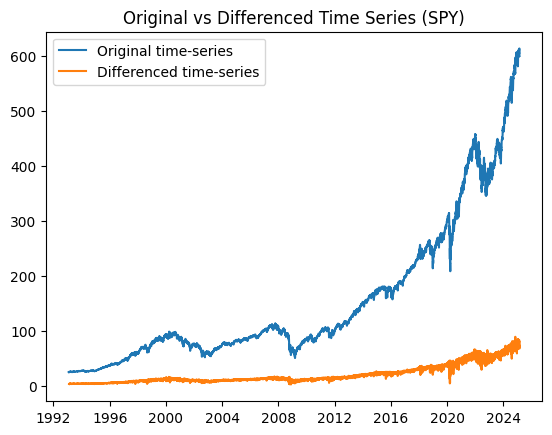

In [88]:
plt.plot(stock, label="Original time-series")
plt.plot(diff_series, label="Differenced time-series")
plt.title(f'Original vs Differenced Time Series ({ticker})')
plt.legend()
plt.show()